In [796]:
import numpy as np
import numpy.linalg as npla
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [797]:
np_train_data = np.array(train_data)
x_train = np_train_data[:, 1:-1]
y_train = np_train_data[:, -1]
# Standardize the data
x_train = (x_train - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0) + 1e-16)
# Add a column of ones to x_train
x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))

np_test_data = np.array(test_data)
x_test = np_test_data[:, 1:]
# Standardize the data
x_test = (x_test - np.mean(x_test, axis=0)) / (np.std(x_test, axis=0) + 1e-16)
# Add a column of ones to x_test
x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))


In [798]:
def sgd(x, y, reg=1e-5, lr=1e-1, a=0.95, tol=1e-3):
    
    w = np.zeros(x.shape[1])
    p = 1 / (1 + np.exp(-np.dot(x, w)))
    
    loss = [np.sum(y * np.log(p) + (1 - y) * np.log(1 - p)) - reg * np.dot(w, w)]

    epoch = 0
    while (True and epoch < 500):
        epoch += 1
        # Shuffle
        ord = np.random.permutation(x.shape[0])
        x = x[ord]
        y = y[ord]
        
        # Update
        for i in range(x.shape[0]):
            w += lr * (y[i] - 1 / (1 + np.exp(-np.dot(x[i], w)))) * x[i] - 2 * reg * w
        
        loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg * np.dot(w, w))
        lr *= a
        print(loss[-1], end='\r')
        # Check convergence
        if np.abs(loss[-1] - loss[-2]) < tol:
            break
    print("Fold done")
    return w, loss

In [799]:
def F1score(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return 2 * tp / (2 * tp + fp + fn)

def split_data(x, y, k, splits):
    n = x.shape[0]
    low = k*n//splits
    high = (k+1)*n//splits
    x_train = np.concatenate((x[:low,:], x[high:,:]), axis=0)
    y_train = np.concatenate((y[:low], y[high:]), axis=0)
    x_test = x[low:high,:]
    y_test = y[low:high]
    return x_train, y_train, x_test, y_test

def cross_validation(x, y, x_t, y_t):
    regs = [1e-5]
    lrs = [1e-1]
    arr = [0.95]
    best = 0
    best_reg = None
    best_lr = None
    best_a = None
    
    for reg in regs:
        for lr in lrs:
            for a in arr:
                w, _ = sgd(x, y, reg=reg, lr=lr, a=a)
                p = 1 / (1 + np.exp(-np.dot(x_t, w)))
                score = F1score(y_t, (p > 0.5).astype(int))
                if score > best:
                    best = score
                    best_reg = reg
                    best_lr = lr
                    best_a = a
    return best_reg, best_lr, best_a, best

In [800]:
best_reg = []
best_lr = []
best_a = []
best = []

for i in range(5):
    x_train_temp, y_train_temp, x_test_temp, y_test_temp = split_data(x_train, y_train, i, 10)
    cv_result = cross_validation(x_train_temp, y_train_temp, x_test_temp, y_test_temp)
    best_reg.append(cv_result[0])
    best_lr.append(cv_result[1])
    best_a.append(cv_result[2])
    best.append(cv_result[3])
    print("reg: ", i, " done")

print(best_reg)
print(best_lr)
print(best_a)
print(best)


/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:18: RuntimeWarning: overflow encountered in exp
  w += lr * (y[i] - 1 / (1 + np.exp(-np.dot(x[i], w)))) * x[i] - 2 * reg * w
/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:20: RuntimeWarning: overflow encountered in exp
  loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg * np.dot(w, w))
/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:20: RuntimeWarning: divide by zero encountered in log
  loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg * np.dot(w, w))
/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:20: RuntimeWarning: invalid value encountered in multiply
  loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg

Fold done1204612678
reg:  0  done
Fold done3378098062
reg:  1  done
Fold done8122473315
reg:  2  done
Fold done3729733474
reg:  3  done
Fold done9773784466
reg:  4  done
[1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
[0.1, 0.1, 0.1, 0.1, 0.1]
[0.95, 0.95, 0.95, 0.95, 0.95]
[0.7397260273972602, 0.7641196013289037, 0.6782006920415224, 0.7615658362989324, 0.7166123778501629]


In [801]:
print(np.mean(best))

0.7320449069833563


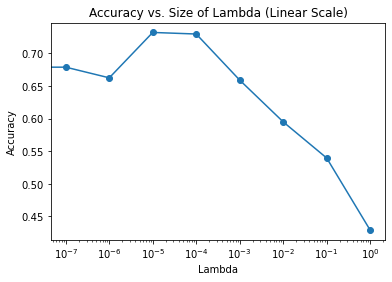

In [813]:
# Plot the accuracy vs. the size of the training set
accs = [0.6877127750997746,
        0.6788183975135565,
        0.6624871392382672,
        0.7320449069833563,
        0.7296310924806243,
        0.6590061849704013,
        0.5950169573833152,
        0.5396357999419127,
        0.4291301087192996]
plt.plot([0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1], accs, 'o-')
plt.xscale('log')
# plt.ylim(0.75, 1)
# plt.xticks(train_size * 100)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Size of Lambda (Linear Scale)')
# Export plot as .png
plt.savefig('logreg_tru.jpg')

In [803]:
# Train
w, loss = sgd(x_train, y_train, reg=1e-5, lr=1e-1, a=0.95, tol=1e-3)

/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:20: RuntimeWarning: divide by zero encountered in log
  loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg * np.dot(w, w))
/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:20: RuntimeWarning: invalid value encountered in multiply
  loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg * np.dot(w, w))
/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:20: RuntimeWarning: overflow encountered in exp
  loss.append(np.sum(y * np.log(1 / (1 + np.exp(-np.dot(x, w)))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-np.dot(x, w))))) - reg * np.dot(w, w))
/var/folders/w_/nbc8427n7xq85wq4ds42bhp80000gp/T/ipykernel_875/76273221.py:18: RuntimeWarning: overflow encountered in exp
  w += lr * (y[i] - 1 / (1 + np.exp(-np.dot(x[i], w)))) * x[

Fold done0771964867


In [804]:
# Test
y_test = 1 / (1 + np.exp(-np.dot(x_test, w)))
predictions = (y_test > 0.5).astype(int)

In [805]:
submit = pd.DataFrame({'id': test_data['id'], 'label': predictions})
submit.to_csv("ans.csv", index=False)